In [64]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

import dtreeviz

from matplotlib import pyplot as plt
from IPython import display

# avoid "Arial font not found warnings"
import logging

logging.getLogger("matplotlib.font_manager").setLevel(level=logging.CRITICAL)

display.set_matplotlib_formats("retina")  # generate hires plots

np.random.seed(1234)  # reproducible plots/data for explanatory reasons

/tmp/tmp.bWlx16VrBv/ipykernel_2953332/4140849731.py:19: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


In [65]:
def split_dataset(dataset, test_ratio=0.30, seed=1234):
    """
    Splits a panda dataframe in two, usually for train/test sets.
    Using the same random seed ensures we get the same split so
    that the description in this tutorial line up with generated images.
    """
    np.random.seed(seed)
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices]

In [66]:
df = pd.read_parquet(
    "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20240725/SPRA/07_25_2024_18:32:07_full_SPRA.parquet"
)
df.head()
print(sorted(df["target_error"].unique()))

[-30.0, -28.0, -25.0, -24.0, -22.0, -19.0, -14.0, -13.0, -12.0, -11.0, -10.0, -9.0, -8.0, -7.0, -6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 41.0, 43.0, 44.0, 62.0, 79.0]


In [67]:
df["target_error"] = df["target_error"].shift(6).fillna(-999)
# Set 'target_error' to 0 if the value is positive
df["target_error"] = df["target_error"].apply(lambda x: x if x < 0 else 0)
df["target_error"] = df["target_error"].apply(lambda x: x if x >= 0 else 1)
print(sorted(df["target_error"].unique()))
t = df["valid_time"].tolist()
df = df.drop(columns="valid_time")
df = df.fillna(-999)
df.head()
df["target_error"] = df["target_error"].astype("category")

[0.0, 1.0]


In [68]:
penguin_label = "target_error"  # Name of the classification target label
classes = list(df[penguin_label].unique())
df[penguin_label] = df[penguin_label].map(classes.index)

In [69]:
classes

[1.0, 0.0]

In [70]:
features = [c for c in df.columns if c != "target_error"]
print(features)

['valid_time_cos', 'valid_time_sin', 't2m_SPRA', 'sh2_SPRA', 'd2m_SPRA', 'r2_SPRA', 'u10_SPRA', 'v10_SPRA', 'tp_SPRA', 'mslma_SPRA', 'tcc_SPRA', 'asnow_SPRA', 'cape_SPRA', 'dswrf_SPRA', 'dlwrf_SPRA', 'gh_SPRA', 'u_total_SPRA', 'u_dir_SPRA', 'new_tp_SPRA', 'lulc_cat_SPRA', 'elev_cat_SPRA', 'slope_cat_SPRA', 't2m_JOHN', 'sh2_JOHN', 'd2m_JOHN', 'r2_JOHN', 'u10_JOHN', 'v10_JOHN', 'tp_JOHN', 'mslma_JOHN', 'tcc_JOHN', 'asnow_JOHN', 'cape_JOHN', 'dswrf_JOHN', 'dlwrf_JOHN', 'gh_JOHN', 'u_total_JOHN', 'u_dir_JOHN', 'new_tp_JOHN', 'lulc_cat_JOHN', 'elev_cat_JOHN', 'slope_cat_JOHN', 't2m_COBL', 'sh2_COBL', 'd2m_COBL', 'r2_COBL', 'u10_COBL', 'v10_COBL', 'tp_COBL', 'mslma_COBL', 'tcc_COBL', 'asnow_COBL', 'cape_COBL', 'dswrf_COBL', 'dlwrf_COBL', 'gh_COBL', 'u_total_COBL', 'u_dir_COBL', 'new_tp_COBL', 'lulc_cat_COBL', 'elev_cat_COBL', 'slope_cat_COBL', 'lat_SPRA', 'lon_SPRA', 'elev_SPRA', 'tair_SPRA', 'ta9m_SPRA', 'td_SPRA', 'relh_SPRA', 'srad_SPRA', 'pres_SPRA', 'mslp_SPRA', 'wspd_sonic_mean_SPRA', 

In [71]:
# Split into training and test sets
train_ds_pd, test_ds_pd = split_dataset(df)
print(
    f"{len(train_ds_pd)} examples in training, {len(test_ds_pd)} examples for testing."
)

34245 examples in training, 14740 examples for testing.


In [72]:
# Convert to tensorflow data sets with specified task
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    train_ds_pd, label=penguin_label, task=tfdf.keras.Task.CLASSIFICATION
)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_ds_pd, label=penguin_label, task=tfdf.keras.Task.CLASSIFICATION
)

In [73]:
# # Define the Gradient Boosted Trees model with custom parameters
# rmodel = tfdf.keras.GradientBoostedTreesModel(
#     task=tfdf.keras.Task.CLASSIFICATION,
#     num_trees=100,             # Number of trees in the ensemble
#     max_depth=6,               # Maximum depth of each tree
#     shrinkage=0.1,             # Learning rate, controls how much each tree contributes
#     subsample=0.8,             # Fraction of the data used for each tree (to prevent overfitting)
#     verbose=1,                 # Verbosity level, set to 1 to see progress
#     random_seed=1234           # Seed for reproducibility
# )

In [74]:
rmodel = tfdf.keras.RandomForestModel(
    task=tfdf.keras.Task.CLASSIFICATION, verbose=0, random_seed=1234
)
rmodel.fit(train_ds)

[INFO 24-08-26 19:44:14.4988 UTC kernel.cc:1233] Loading model from path /tmp/tmp.bWlx16VrBv/tmpbxd2671v/model/ with prefix 52003a268f354e59
[INFO 24-08-26 19:44:14.7744 UTC decision_forest.cc:734] Model loaded with 300 root(s), 174632 node(s), and 92 input feature(s).
[INFO 24-08-26 19:44:14.7744 UTC abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-08-26 19:44:14.7744 UTC kernel.cc:1061] Use fast generic engine


In [75]:
# Compile the model with appropriate metrics for regression
rmodel.compile(metrics=["accuracy"])

In [76]:
# # Train a Random Forest model
# cmodel = tfdf.keras.RandomForestModel(verbose=0, random_seed=1234)
# y_train = cmodel.fit(train_ds)

In [77]:
y_test = rmodel.evaluate(test_ds, return_dict=True, verbose=0)
print(y_test)

{'loss': 0.0, 'accuracy': 0.9834464192390442}


In [78]:
import numpy as np


# Function to get predictions
def get_predictions(dataset):
    # Extract the true labels from the dataset
    y_true = np.concatenate([y for x, y in dataset], axis=0)

    # Predict probabilities using the model
    y_pred_prob = rmodel.predict(dataset).reshape(-1)

    # Convert probabilities to binary class labels (0 or 1) using a threshold of 0.5
    y_pred = (y_pred_prob > 0.95).astype(int)

    return y_true, y_pred

In [79]:
y_true_0, y_pred_0 = get_predictions(train_ds)
y_true_1, y_pred_1 = get_predictions(test_ds)

y_true = np.concatenate([y_true_0, y_true_1])
y_pred = np.concatenate([y_pred_0, y_pred_1])

 1/35 [..............................] - ETA: 5s

2024-08-26 19:44:19.095720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


 1/15 [=>............................] - ETA: 2s

2024-08-26 19:44:21.957734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


15/15 [==============================] - 1s 56ms/step


In [80]:
rmodel.summary()

Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (110):
	asnow_COBL
	asnow_JOHN
	asnow_SPRA
	cape_COBL
	cape_JOHN
	cape_SPRA
	d2m_COBL
	d2m_JOHN
	d2m_SPRA
	dlwrf_COBL
	dlwrf_JOHN
	dlwrf_SPRA
	dswrf_COBL
	dswrf_JOHN
	dswrf_SPRA
	elev_COBL
	elev_JOHN
	elev_SPRA
	elev_cat_COBL
	elev_cat_JOHN
	elev_cat_SPRA
	gh_COBL
	gh_JOHN
	gh_SPRA
	lat_COBL
	lat_JOHN
	lat_SPRA
	lon_COBL
	lon_JOHN
	lon_SPRA
	lulc_cat_COBL
	lulc_cat_JOHN
	lulc_cat_SPRA
	mslma_COBL
	mslma_JOHN
	mslma_SPRA
	mslp_COBL
	mslp_JOHN
	mslp_SPRA
	new_tp_COBL
	new_tp_JOHN
	new_tp_SPRA
	precip_total_COBL
	precip_total_JOHN
	precip_total_SPRA
	pres_COBL
	pres_JOHN
	pres_SPRA
	r2_COBL
	r2_

In [81]:
# Get the feature importance from the model inspector
inspector = rmodel.make_inspector()

# Check available types of feature importances
available_importance_types = inspector.variable_importances().keys()
print("Available importance types:", available_importance_types)

Available importance types: dict_keys(['INV_MEAN_MIN_DEPTH', 'SUM_SCORE', 'NUM_AS_ROOT', 'NUM_NODES'])


In [82]:
# Get the feature importance based on 'INV_MEAN_MIN_DEPTH'
importances = inspector.variable_importances()["NUM_NODES"]

# Sort the importances in descending order based on the importance value (second element of the tuple)
sorted_importances = sorted(importances, key=lambda x: x[1], reverse=False)

# Display the sorted feature importances
for feature, importance in sorted_importances:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: "asnow_COBL" (1; #1), Importance: 190.0
Feature: "asnow_SPRA" (1; #3), Importance: 228.0
Feature: "asnow_JOHN" (1; #2), Importance: 259.0
Feature: "snow_depth_JOHN" (1; #62), Importance: 427.0
Feature: "cape_JOHN" (1; #5), Importance: 431.0
Feature: "cape_COBL" (1; #4), Importance: 453.0
Feature: "dswrf_COBL" (1; #13), Importance: 453.0
Feature: "snow_depth_COBL" (1; #61), Importance: 459.0
Feature: "cape_SPRA" (1; #6), Importance: 460.0
Feature: "precip_total_JOHN" (1; #44), Importance: 499.0
Feature: "snow_depth_SPRA" (1; #63), Importance: 505.0
Feature: "precip_total_COBL" (1; #43), Importance: 521.0
Feature: "precip_total_SPRA" (1; #45), Importance: 537.0
Feature: "dswrf_SPRA" (1; #15), Importance: 550.0
Feature: "dswrf_JOHN" (1; #14), Importance: 634.0
Feature: "tcc_SPRA" (1; #78), Importance: 760.0
Feature: "tcc_COBL" (1; #76), Importance: 764.0
Feature: "new_tp_COBL" (1; #40), Importance: 774.0
Feature: "t2m_SPRA" (1; #69), Importance: 781.0
Feature: "tair_SPRA" (1; #75

In [83]:
# Check the task
print(f"Model Task: {rmodel.task}")

Model Task: 1


In [84]:
print(np.unique(y_pred))

[0 1]


In [93]:
# import matplotlib.pyplot as pl

# s = -4000
# f = -1

# plt.figure(figsize=(15, 9))
# plt.plot(t[s:f], y_true[s:f], label="Target")
# plt.plot(t[s:f], y_pred[s:f], label="RF Prediction", alpha=0.5)
# plt.legend()
# plt.show()

In [94]:
y_true

array([0, 0, 0, ..., 1, 1, 1])

In [95]:
y_pred

array([0, 0, 0, ..., 1, 1, 1])

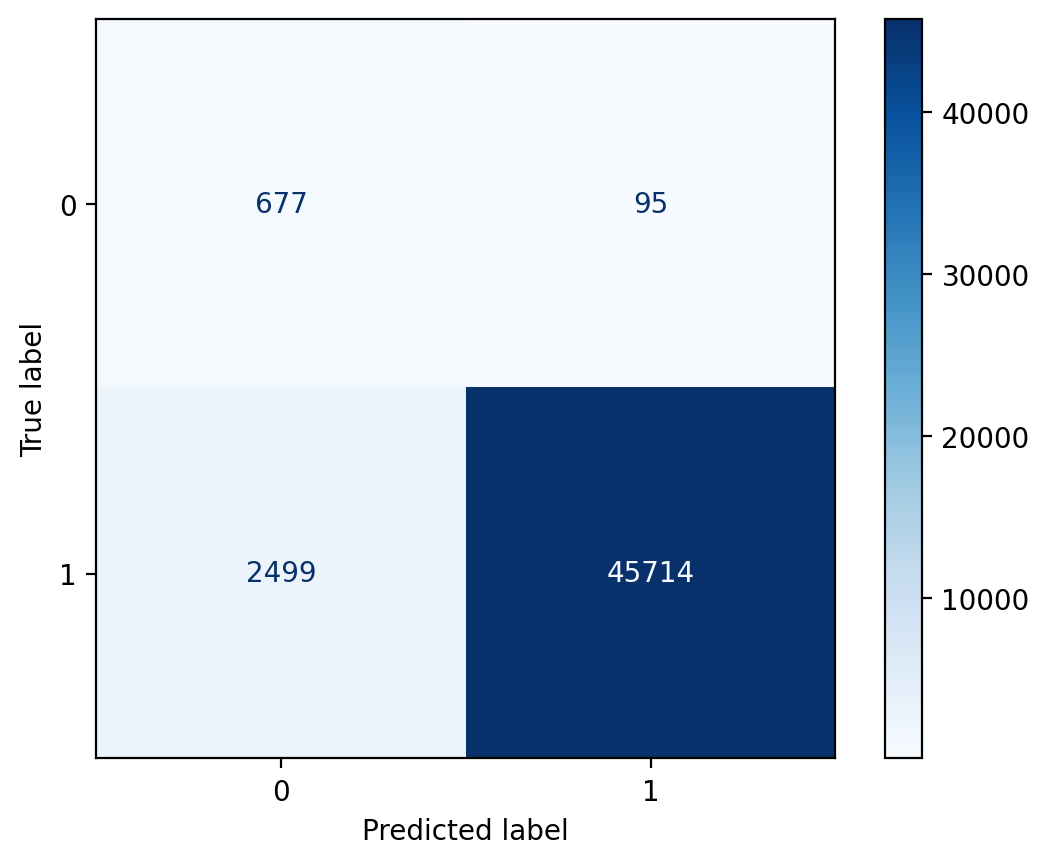

In [96]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

# Show the plot
plt.show()